In [1]:
%matplotlib inline

import sys
import os
sys.path.append('/Users/selimamrari/Documents/PDM/NCP')

import numpy as np
import re

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import exposure, img_as_float, morphology, color
from skimage.measure import label
from sklearn.model_selection import KFold
from PIL import Image
import xml.etree.ElementTree as ET

from osgeo import gdal
import osr
from my_packages.My_Geoprocess import*
import pandas as pd


In [2]:
help(KFold)

Help on class KFold in module sklearn.model_selection._split:

class KFold(_BaseKFold)
 |  K-Folds cross-validator
 |  
 |  Provides train/test indices to split data in train/test sets. Split
 |  dataset into k consecutive folds (without shuffling by default).
 |  
 |  Each fold is then used once as a validation while the k - 1 remaining
 |  folds form the training set.
 |  
 |  Read more in the :ref:`User Guide <cross_validation>`.
 |  
 |  Parameters
 |  ----------
 |  n_splits : int, default=3
 |      Number of folds. Must be at least 2.
 |  
 |  shuffle : boolean, optional
 |      Whether to shuffle the data before splitting into batches.
 |  
 |  random_state : int, RandomState instance or None, optional, default=None
 |      If int, random_state is the seed used by the random number generator;
 |      If RandomState instance, random_state is the random number generator;
 |      If None, the random number generator is the RandomState instance used
 |      by `np.random`. Used when

# Declare model class

In [58]:
class LyzengaMod:
    
    """Classe définissant un model bathymetrique de type lyzenga.
    
    Elle possède comme attributs :
    H -- Un ensemble de parametre
    Score -- Un score
    """
    from sklearn.metrics import r2_score

    
    def get_X(DeepSample, FootPrint, SoilIndex, bands_data):
        assert str(bands_data.dtype) == 'float32'
        X = np.zeros(bands_data.shape, dtype= np.float32)
        SoilIndex5D = np.tile(SoilIndex[:,:,np.newaxis], (1,1,bands_data.shape[2]))

        for i in range(len(FootPrint)):
            Idx = np.logical_and( np.logical_and(FootPrint[i], ~SoilIndex), np.sum(X == 0, axis=2)>0)

            if np.sum(Idx) > 0:
                IdxDeep = np.logical_and(FootPrint[i], DeepSample)
                if np.sum(IdxDeep) == 0:
                    IdxDeep = np.logical_and(FootPrint[i-1], DeepSample)

                for c in range(bands_data.shape[2]):
                    X[:,:,c][Idx] = bands_data[:,:,c][Idx] - np.min(bands_data[:,:,c][IdxDeep])
                    print('FootPrint: {0:d}, Bande: {1:d}, minimum :{2:0.2f}, average :{3:0.2f}'.format(i,c,np.min(bands_data[:,:,c][IdxDeep]), np.mean(bands_data[:,:,c][IdxDeep])))

        ErrorMap = np.logical_and(X<=0, ~SoilIndex5D)
        X[ErrorMap] = np.nan
        X[~SoilIndex5D] = np.log(X[~SoilIndex5D])
        return X, ErrorMap
        
    def fit(self, lnX, Y):
        assert lnX.shape[0] == Y.shape[0]
        
        lnX = np.hstack((np.ones((lnX.shape[0],1)), lnX))
        self.Parameters = np.linalg.solve(lnX.T.dot(lnX), lnX.T.dot(Y))
        
        ecart = lnX.dot(self.Parameters) - Y
        N = len(ecart)
        self.score = {'averageDev':np.sum(ecart)/N, 'Var':np.sum(np.square(ecart))/N,'RMS':np.sum(np.sqrt(ecart**2))/N, 'Error%':np.mean(np.abs(ecart)/Y), 'Error':np.sum(np.abs(ecart)), 'R2': r2_score(Y, lnX.dot(self.Parameters))}
        
    def fit2(self, lnX, Y):
        assert lnX.shape[0] == Y.shape[0]
        print('ok')
        
    def predict(self, lnX):
        
        lnX = np.hstack((np.ones((lnX.shape[0],1)), lnX))
        assert lnX.shape[1] == self.Parameters.shape[0]
        
        return lnX.dot(self.Parameters)
    
    def predictEval(self, lnX, Y):
        
        assert lnX.shape[0] == Y.shape[0]
        lnX = np.hstack((np.ones((lnX.shape[0],1)), lnX))
        
        ecart = lnX.dot(self.Parameters) - Y
        N = len(ecart)
        self.Testscore = {'averageDev':np.sum(ecart)/N, 'Var':np.sum(np.square(ecart))/N,'RMS':np.sum(np.sqrt(ecart**2))/N, 'Error%':np.mean(np.abs(ecart)/Y),'Error':np.sum(np.abs(ecart)), 'R2': r2_score(Y, lnX.dot(self.Parameters))}
        
         
        return lnX.dot(self.Parameters)
    
    def __init__(self):
        """Constructeur de notre personne."""
        self.Parameters = np.array
        self.score = {}
        self.Testscore = {}

In [4]:
class StumpfMod:
    
    """Classe définissant un model bathymetrique de type lyzenga.
    
    Elle possède comme attributs :
    H -- Un ensemble de parametre
    Score -- Un score
    """
    from sklearn.metrics import r2_score

    
    def get_X(DeepSample, FootPrint, SoilIndex, bands_data):
        assert str(bands_data.dtype) == 'float32'
        X = np.zeros(bands_data.shape, dtype= np.float32)
        SoilIndex5D = np.tile(SoilIndex[:,:,np.newaxis], (1,1,bands_data.shape[2]))

        for i in range(len(FootPrint)):
            Idx = np.logical_and( np.logical_and(FootPrint[i], ~SoilIndex), np.sum(X == 0, axis=2)>0)

            if np.sum(Idx) > 0:
                IdxDeep = np.logical_and(FootPrint[i], DeepSample)
                if np.sum(IdxDeep) == 0:
                    IdxDeep = np.logical_and(FootPrint[i-1], DeepSample)

                for c in range(bands_data.shape[2]):
                    X[:,:,c][Idx] = bands_data[:,:,c][Idx] - np.min(bands_data[:,:,c][IdxDeep])
                    print('FootPrint: {0:d}, Bande: {1:d}, minimum :{2:0.2f}, average :{3:0.2f}'.format(i,c,np.min(bands_data[:,:,c][IdxDeep]), np.mean(bands_data[:,:,c][IdxDeep])))

        ErrorMap = np.logical_and(X<=0, ~SoilIndex5D)
        X[ErrorMap] = np.nan
        X[~SoilIndex5D] = np.log(X[~SoilIndex5D])
        return X, ErrorMap
        
    def fit(self, Ratio, Y):
        assert lnRatio.shape[0] == Y.shape[0]
        
        lnRatio = np.hstack((lnRatio, -1*np.ones((lnRatio.shape[0],1))))
        self.Parameters = np.linalg.solve(lnRatio.T.dot(lnRatio), lnRatio.T.dot(Y))
        
        ecart = lnRatio.dot(self.Parameters) - Y
        N = len(ecart)
        self.score = {'averageDev':np.sum(ecart)/N, 'Var':np.sum(np.square(ecart))/N,'RMS':np.sum(np.sqrt(ecart**2))/N, 'R2': r2_score(Y, lnX.dot(self.Parameters))}
        
    def GetRatios(self, lnRatios, Y):
        assert lnX.shape[0] == Y.shape[0]
        print('ok')
        
    def predict(self, lnX):
        
        lnX = np.hstack((np.ones((lnX.shape[0],1)), lnX))
        assert lnX.shape[1] == self.Parameters.shape[0]
        
         
        return lnX.dot(self.Parameters)
    
    def __init__(self):
        """Constructeur de notre personne."""
        print("Appel de la méthode __init__")
        self.Parameters = np.array
        self.score = {}

# Open Satellite file and deglingt image

In [5]:
xml_filePath = "/Users/selimamrari/Documents/PDM/NCP/Image/Sen2/S2A_MSIL1C_20170718T231141_N0205_R101_T58KFA_20170718T231219.SAFE/"
xml_fileName = "MTD_MSIL1C.xml"
gdal.ErrorReset()
ds = gdal.Open( xml_filePath + xml_fileName )

if ds is None or gdal.GetLastErrorMsg() != '':
    print('xml failed to load')
    
DataSet_md = ds.GetMetadata()
SubDataSet_md = ds.GetMetadata('SUBDATASETS')
ds = []
DataSet_md


{'CLOUD_COVERAGE_ASSESSMENT': '0.7371',
 'DATATAKE_1_DATATAKE_SENSING_START': '2017-07-18T23:11:41.026Z',
 'DATATAKE_1_DATATAKE_TYPE': 'INS-NOBS',
 'DATATAKE_1_ID': 'GS2A_20170718T231141_010823_N02.05',
 'DATATAKE_1_SENSING_ORBIT_DIRECTION': 'DESCENDING',
 'DATATAKE_1_SENSING_ORBIT_NUMBER': '101',
 'DATATAKE_1_SPACECRAFT_NAME': 'Sentinel-2A',
 'DEGRADED_ANC_DATA_PERCENTAGE': '0',
 'DEGRADED_MSI_DATA_PERCENTAGE': '0',
 'FOOTPRINT': 'POLYGON((166.35532632901763 -21.6970894719947, 166.46954229960608 -21.722967647825207, 166.46958826624325 -21.7227815159352, 166.47163316358743 -21.7232445791535, 166.4716453848504 -21.723194893765147, 166.47183341263485 -21.72323722848605, 166.4718497080836 -21.72317095690131, 166.71071733633568 -21.7773031127493, 166.71050830013448 -21.778173871448455, 166.9264041597562 -21.83047594674156, 166.92645036494807 -21.830281694363315, 166.92658079158798 -21.830313185021467, 166.9266070084699 -21.830202736161407, 166.92874668649648 -21.830719126399448, 166.928830

In [6]:
# Try opening the 4 subdatasets
for i in range(4):
    gdal.ErrorReset()
    ds.append(gdal.Open(SubDataSet_md['SUBDATASET_%d_NAME' % (i+1)]))
    if ds is None or gdal.GetLastErrorMsg() != '':
        print('subdatasets failed to load')
        print(SubDataSet_md['SUBDATASET_%d_NAME' % (i+1)])
src_ds = ds[0]
ds[0].RasterCount

4

# Define image extent

In [7]:
# Define Raster Footprint

RasterWidth = src_ds.RasterXSize
RasterHeight = src_ds.RasterYSize
GT_ds = src_ds.GetGeoTransform()
min_x = GT_ds[0]
min_y = GT_ds[3] + RasterWidth*GT_ds[4] + RasterHeight*GT_ds[5] 
max_x = GT_ds[0] + RasterWidth*GT_ds[1] + RasterHeight*GT_ds[2]
max_y = GT_ds[3]   

srs_ds = osr.SpatialReference()
srs_ds.ImportFromWkt(src_ds.GetProjection())

srsLatLong = srs_ds.CloneGeogCS()
ct_ds = osr.CoordinateTransformation(srs_ds,srsLatLong)

min_E, min_N = ct_ds.TransformPoint(min_x, min_y)[:2]
max_E, max_N = ct_ds.TransformPoint(max_x, max_y)[:2]

print('Upper left corner : ', (min_E, min_N), '\nLower right corner : ', (max_E, max_N))


Upper left corner :  (165.9735606070099, -22.692427357900442) 
Lower right corner :  (167.02786117314153, -21.691015824552036)


# Select xml datafiles following common extent

In [8]:
RePath_xmlDirectory = '/Users/selimamrari/Documents/PDM/NCP/Data_SHOM/Global'
TimeThres = 1970
#%timeit GetXml_byFootprint(RePath_xmlDirectory,(min_E, max_E), (min_N, max_N))
#%timeit GetXml_byFootprint2(RePath_xmlDirectory, min_E, max_E, min_N, max_N)
Selected_xml, LoopCount, count = GetXml_byFootprint(RePath_xmlDirectory,(min_E, max_E), (min_N, max_N), FromYear=TimeThres)

# Select xml datafiles following maximum depth

In [9]:
Upto = 25
Set , Count, failedXml = GetSurvey_byDepthFP(Selected_xml, RePath_xmlDirectory,(min_E, max_E), (min_N, max_N), max_Depth=Upto)
assert np.sum(Count) == Set[1].shape[0]


# Define pixel location of measured data

In [10]:
ctInv = osr.CoordinateTransformation(srsLatLong, srs_ds)
inv_geometrix = gdal.InvGeoTransform(GT_ds)

px, py = GetPixel(ctInv, inv_geometrix, Set[1])


with int


# filter measured data projected outside image extent

In [11]:
index = np.logical_or(np.logical_or(py>10979,py<0), np.logical_or(px>10979,px<0))
px, py = px[~index], py[~index]
depth=Set[2][~index]

# Import image data index as compressed

In [12]:
npzfile = np.load('TrainMatrix_all.npz')
ClassifIndex =  npzfile['arr_1']

# Create sub (2d) index for measured pixel

In [13]:
SurveyIndex = np.full(ClassifIndex.shape, False, dtype=np.bool_)
SurveyValues = np.full(ClassifIndex.shape, np.NaN, dtype= np.float_)
for i in range(len(px)):
    try:
        SurveyIndex[py[i],px[i]] = True
        SurveyValues[py[i],px[i]] = depth[i]
    except:
        print(i)

In [30]:
np.sum(SurveyValues>0)

/Users/selimamrari/anaconda/envs/GdalV3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in greater
  """Entry point for launching an IPython kernel.


562277

In [14]:
SurveyIndex = np.full(ClassifIndex.shape, 0, dtype=np.int8)
Dicto = {}
for i in range(len(px)):
    try:
        if ClassifIndex[py[i],px[i]] == False:
            continue
        SurveyIndex[py[i],px[i]] += 1
        if SurveyIndex[py[i],px[i]] == 1:
            Dicto[(py[i],px[i])] = [depth[i]]
        else:
            Dicto[(py[i],px[i])].append(depth[i])
    except:
        print(i)


In [15]:
SurveyValues = np.full(ClassifIndex.shape, np.NaN, dtype= np.float_)
SurveyVariance = np.full(ClassifIndex.shape, np.NaN, dtype= np.float_)
for i, j  in Dicto.keys():
    SurveyValues[i, j] = np.mean(Dicto[(i, j)])
    SurveyVariance[i, j] = np.std(Dicto[(i, j)])
    

In [17]:
Dicto[(i, j-1)]

[2.3999999999999999,
 2.6000000000000001,
 2.6000000000000001,
 2.6000000000000001,
 2.7000000000000002,
 2.7000000000000002,
 2.7999999999999998,
 2.8999999999999999,
 2.7999999999999998,
 2.8999999999999999,
 2.8999999999999999,
 2.8999999999999999,
 2.8999999999999999,
 2.7999999999999998,
 2.8999999999999999,
 2.8999999999999999,
 2.8999999999999999,
 2.8999999999999999,
 2.8999999999999999,
 2.8999999999999999,
 2.8999999999999999,
 2.8999999999999999,
 2.8999999999999999,
 2.7000000000000002,
 2.7000000000000002,
 2.8999999999999999,
 2.8999999999999999,
 2.8999999999999999,
 2.8999999999999999,
 2.7999999999999998,
 2.8999999999999999,
 2.7999999999999998,
 2.7999999999999998,
 2.8999999999999999,
 2.8999999999999999,
 2.8999999999999999,
 2.8999999999999999,
 2.8999999999999999,
 2.8999999999999999,
 2.7999999999999998,
 2.8999999999999999,
 2.8999999999999999,
 2.8999999999999999,
 2.8999999999999999,
 2.8999999999999999,
 2.7999999999999998,
 2.8999999999999999,
 2.7999999999

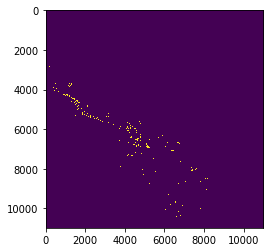

In [183]:
test = np.full(ClassifIndex.shape, False, dtype= np.float_)

for i, j  in Dicto.keys():
    test[i, j] = True
    
plt.imshow(test)

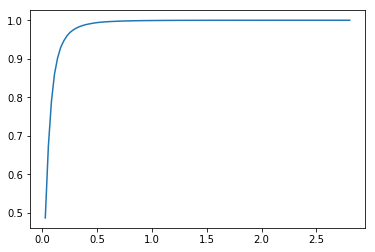

0.033071891388307267

In [184]:
values, base = np.histogram(SurveyVariance[~np.isnan(SurveyVariance)], bins=100, normed='True')
dx = base[1] - base[0]
plt.plot(base[1:], np.cumsum(values)*dx)
plt.show()
np.median(SurveyVariance[~np.isnan(SurveyVariance)])

In [24]:
index = SurveyVariance < np.percentile(SurveyVariance[~np.isnan(SurveyVariance)],100)

/Users/selimamrari/anaconda/envs/GdalV3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


In [57]:
np.sum(np.isnan(index))

0

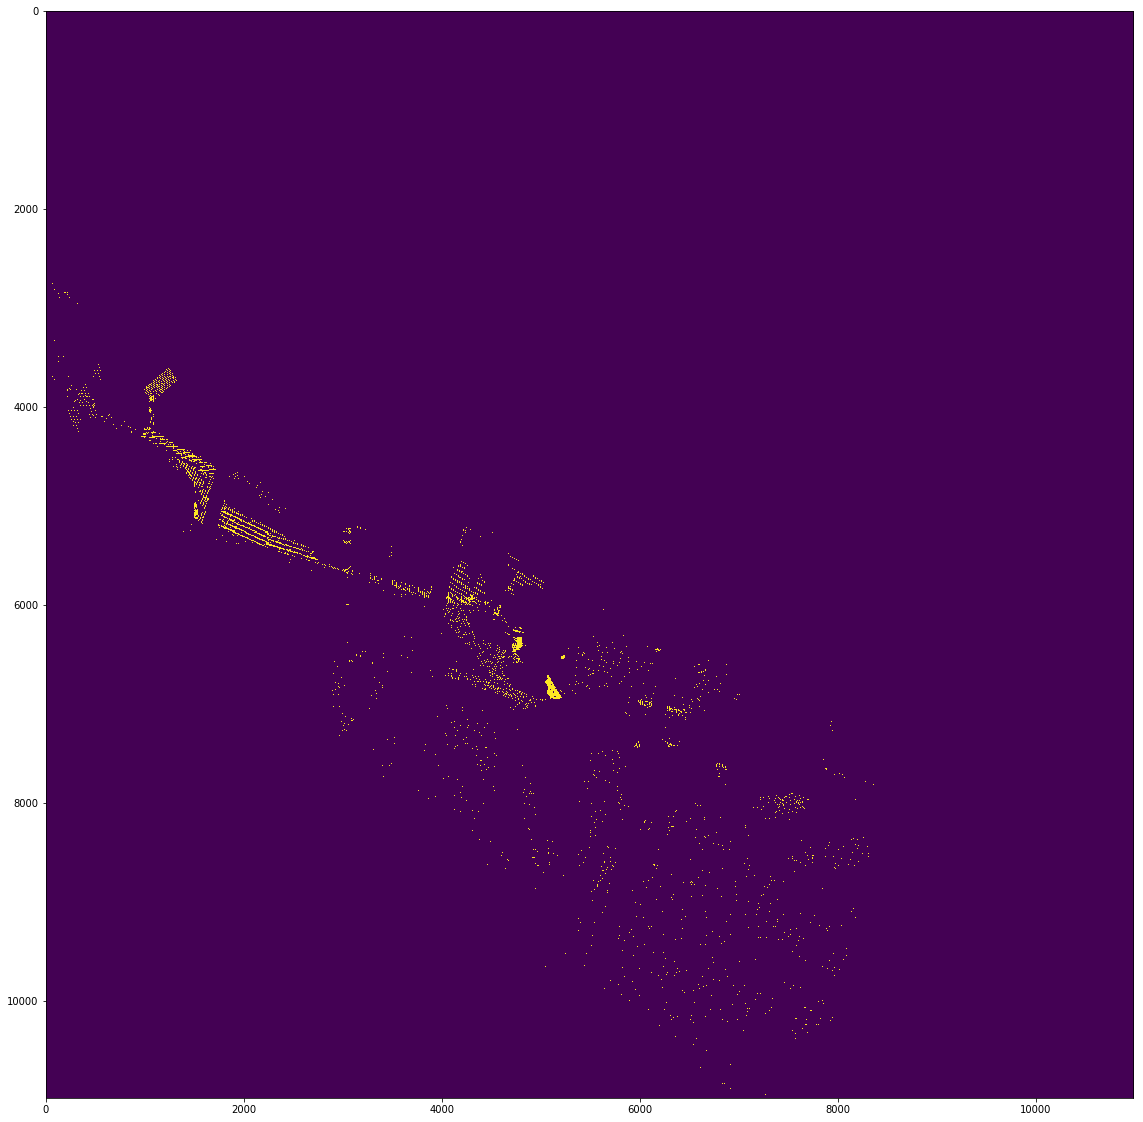

In [16]:
fig = plt.figure(figsize=(20,20))
plt.imshow(ClassifIndex* (SurveyIndex>0))

# Import image data

In [18]:
npzfile = np.load('X_Package__all.npz')
X = npzfile['arr_0']

In [20]:
Classif_Tiff_File = 'classtest8Clustbisall82017-.11-29_08.32.16.tif'
Classif = gdal.Open( Classif_Tiff_File )
clusters_Classif = Classif.GetRasterBand(1).ReadAsArray()
np.unique(clusters_Classif)

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=uint16)

In [21]:
np.unique(clusters_Classif)

array([0, 1, 2, 3, 4, 5, 6, 7, 8], dtype=uint16)

In [26]:
for i in np.unique(clusters_Classif):
    if i ==0:
        continue
    ind = (clusters_Classif==i) * (SurveyIndex>0) 
    print(str(i)+':  '+str(np.sum(ind))+ ' et    '+ str(np.median(SurveyValues[ind]))+ ' et    '+str(np.std(SurveyValues[ind])))


1:  4150 et    21.88875 et    3.51649906443
2:  133711 et    16.4 et    4.9305359376
3:  22015 et    12.5 et    7.55035061841
4:  87278 et    17.1 et    6.08766967834
5:  92707 et    19.8819444444 et    3.13300776113
6:  3687 et    7.12857142857 et    2.58551808208
7:  3950 et    6.25611111111 et    5.11545685775
8:  21062 et    11.0 et    3.71458032857


In [23]:
index.shape

(10866739,)

In [22]:
np.sum(np.isnan(X[ind]))
1:  4152 et    21.9 et    3.51852507607
2:  136640 et    16.3 et    4.96364653415
3:  22407 et    12.2 et    7.53041328939
4:  87522 et    17.1 et    6.09527585898
5:  92856 et    19.9 et    3.14291444968
6:  3687 et    7.1 et    2.58773980861
7:  4011 et    6.2 et    5.08833899814
8:  21232 et    11.0 et    3.73802463269

0

In [59]:
ind = (clusters_Classif==2) * (SurveyIndex>0) * index
testmode = LyzengaMod()
testmode.fit(X[ind], SurveyValues[ind].reshape(np.sum(ind),1))
testmode.score

{'Error': 214834.83325386772,
 'Error%': 0.2047123701592195,
 'R2': 0.46289608574909114,
 'RMS': 2.7541514954857149,
 'Var': 12.096923964727713,
 'averageDev': 1.468015323510304e-13}

# Grid Search on each class model

In [60]:

models = {}
count = 1 
ClasseParameter = {}
BestParam = {}
PercentilRange = range(50, 101, 5)
FoldsScores = {}
NK_fold = 4

# Class and model initialization
for c in np.unique(clusters_Classif):
    # Avoid empty class
    if c ==0:
        continue
    print('Processing class' + str(c))
    models[c] = LyzengaMod()
    BestParam[c] = {}
    ClasseParameter[c] = {}
    
    # Grid Search on hyperParam
    PercentScores = {}      
    for bornIndex in PercentilRange:
        PercentScores[bornIndex] = {}
        index = SurveyVariance < np.percentile(SurveyVariance[~np.isnan(SurveyVariance)],bornIndex)
        ind = (clusters_Classif==c) * (SurveyIndex>0) * index
        Xk, Yk = X[ind], SurveyValues[ind].reshape(np.sum(ind),1)
        
        # FoldScore initialization
        for ScoreName in testmode.score.keys():
            FoldsScores[ScoreName] = []
        
        # Initialize folder
        skf = KFold(n_splits=NK_fold)
        skf.get_n_splits(Xk, Yk)#'''Line to check and updated with stratified'''
        # Validation on k folds
        for trI, teI in skf.split(X[ind], SurveyValues[ind].reshape(np.sum(ind),1)):
            models[c].fit(Xk[trI], Yk[trI])
            models[c].predictEval(Xk[teI], Yk[teI])
            
            # Foldscores recording
            for ScoreName in models[c].Testscore.keys():
                FoldsScores[ScoreName].append(models[c].Testscore[ScoreName])
                
        # Average Foldscore recording on percentile parameter
        for ScoreName in testmode.score.keys():        
            PercentScores[bornIndex][ScoreName] = np.mean(FoldsScores[ScoreName])
    
    # Best scores recording along all average Foldscore depending on percentile parameter
    for bornIndex in PercentilRange:    
        for ScoreName in testmode.score.keys():
            ClasseParameter[c][ScoreName] = np.argmin([PercentScores[k][ScoreName] for k in PercentScores.keys()])
            BestParam[c][ScoreName] = np.min([PercentScores[k][ScoreName] for k in PercentScores.keys()])
    print('Best Scores for class '+ str(c) + ', with  ' + str(PercentilRange[ClasseParameter[c]['R2']])+' :')
    print(BestParam[c])
    print( 10*'=')

Processing class1


/Users/selimamrari/anaconda/envs/GdalV3/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in less


Best Scores for class 1, with  50 :
{'averageDev': -0.22071338914320585, 'Var': 5.318367297309746, 'RMS': 1.4230200318223074, 'Error%': 0.56565242610169908, 'Error': 801.33288138004218, 'R2': -0.43267581391690851}
Processing class2
Best Scores for class 2, with  65 :
{'averageDev': 0.052256131960476515, 'Var': 14.00920220323982, 'RMS': 3.0214109900091661, 'Error%': 0.22176856292591207, 'Error': 58920.535716168743, 'R2': -0.088193750271085086}
Processing class3
Best Scores for class 3, with  50 :
{'averageDev': 0.1994097937530715, 'Var': 18.928174688467585, 'RMS': 3.6172080266745228, 'Error%': 0.88812754380907666, 'Error': 14285.964877035083, 'R2': -0.27107546890782624}
Processing class4
Best Scores for class 4, with  70 :
{'averageDev': 0.23634530610092461, 'Var': 24.949085272508299, 'RMS': 4.1809027905900642, 'Error%': 0.48727350661770941, 'Error': 47022.266198929283, 'R2': -0.030926296842384071}
Processing class5
Best Scores for class 5, with  60 :
{'averageDev': 0.071114837128619213

# Models computation folowing best parameters for each class

/Users/selimamrari/anaconda/envs/GdalV3/lib/python3.6/site-packages/ipykernel_launcher.py:11: RuntimeWarning: invalid value encountered in less
  # This is added back by InteractiveShellApp.init_path()


{'averageDev': -3.7176075626266849e-15, 'Var': 9.1404292425647959, 'RMS': 2.0538355542980651, 'Error%': 1.7945858773095091, 'Error': 2920.5541582118485, 'R2': 0.62405176487060443}
{'averageDev': 1.468015323510304e-13, 'Var': 12.096923964727713, 'RMS': 2.7541514954857149, 'Error%': 0.2047123701592195, 'Error': 214834.83325386772, 'R2': 0.46289608574909114}
{'averageDev': -5.5425555805323011e-15, 'Var': 15.54805614567382, 'RMS': 3.3657962056686856, 'Error%': 0.77006332627594809, 'Error': 47498.116054396494, 'R2': 0.68679018617391208}
{'averageDev': 4.2238985558204759e-14, 'Var': 21.908129357005336, 'RMS': 3.9362814170456111, 'Error%': 0.52265269129887315, 'Error': 153070.17546465268, 'R2': 0.39747983974378343}
{'averageDev': 1.4690200365375188e-14, 'Var': 7.2000966949868328, 'RMS': 2.1709968934429322, 'Error%': 0.11821858854540818, 'Error': 76076.073140027234, 'R2': 0.21270982896094803}
{'averageDev': -6.6357605318763122e-15, 'Var': 1.1805442183117443, 'RMS': 0.71401732222752845, 'Error%

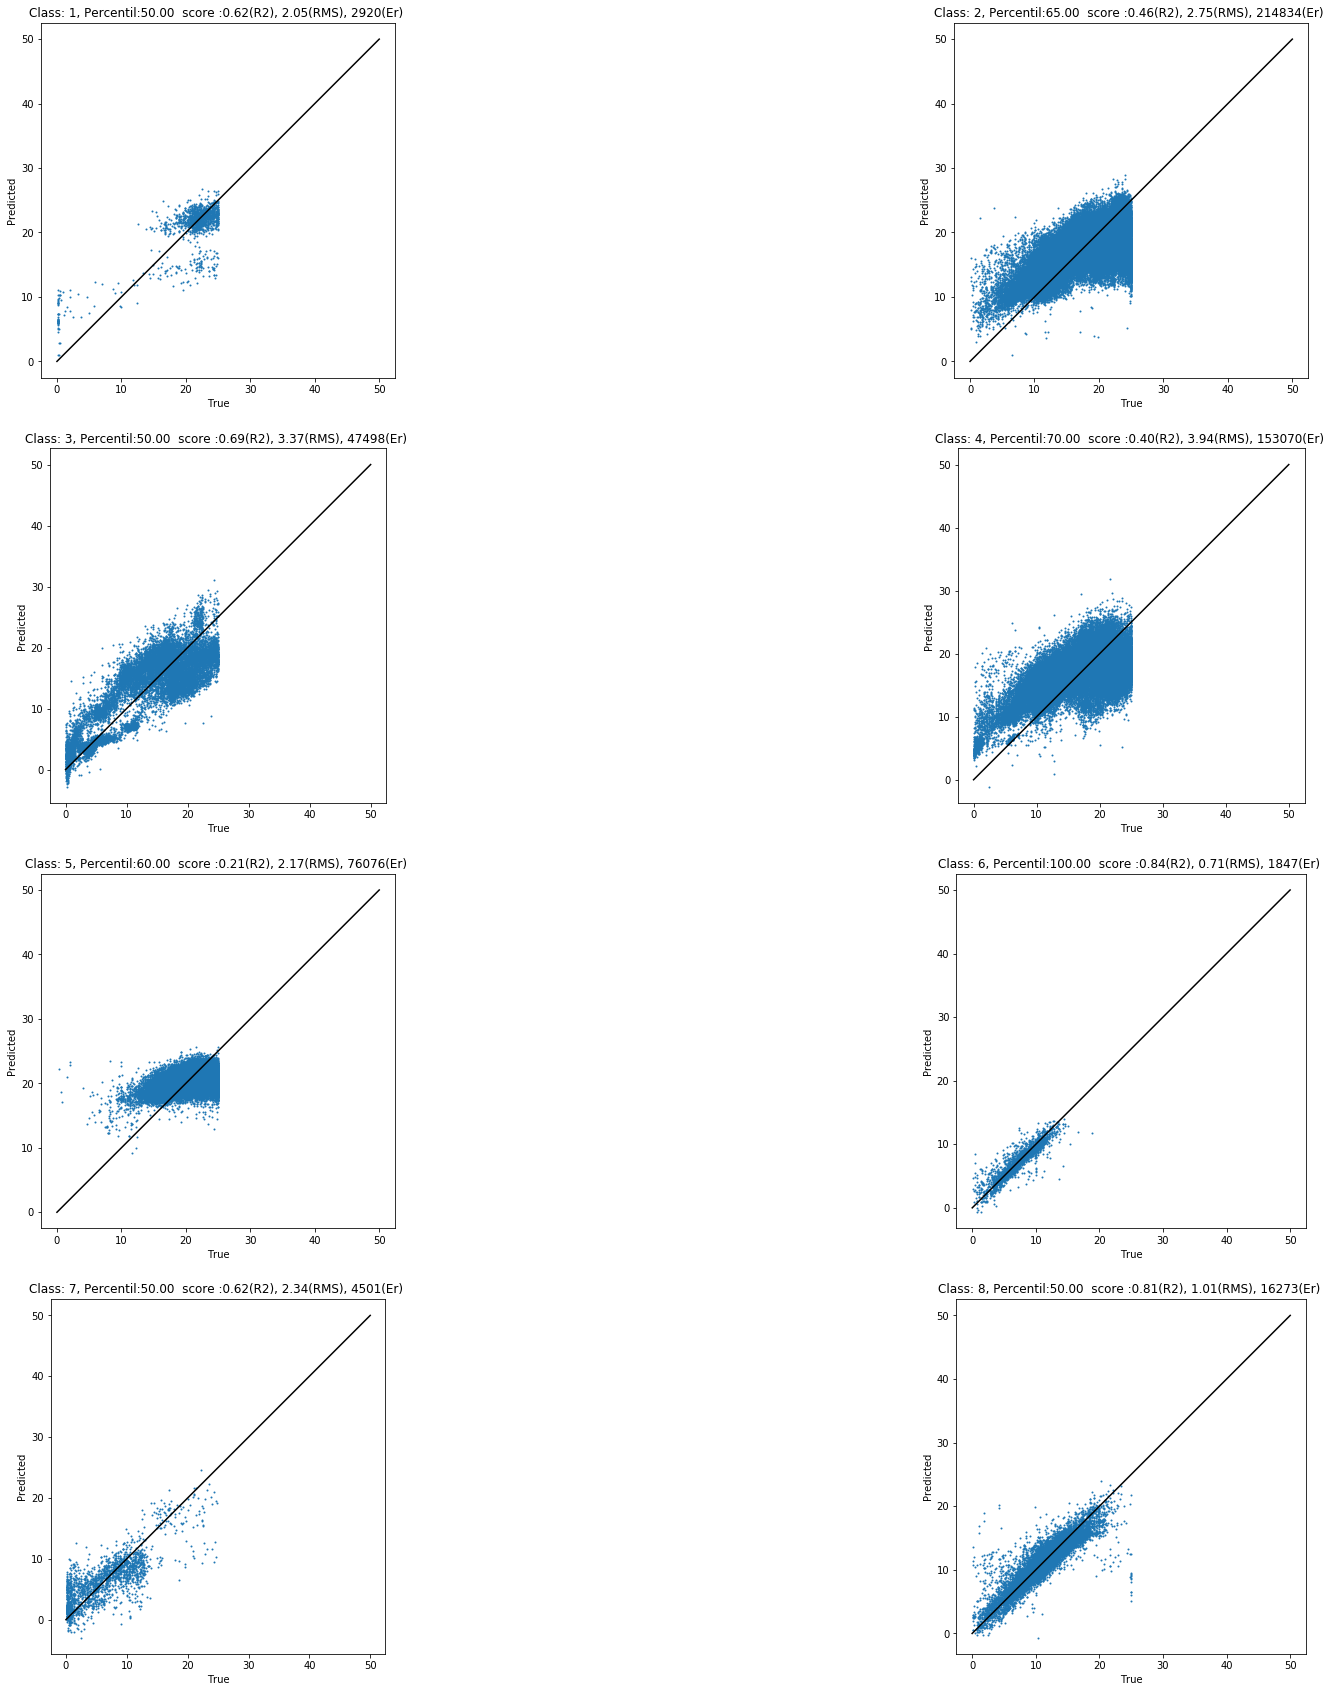

In [67]:
plt.figure(figsize=(30, 30))
count = 1 

# Class and model initialization
for c in np.unique(clusters_Classif):
    if c ==0:
        continue
    models[c] = LyzengaMod()
    
    # Index definition following Variance and class
    index = SurveyVariance < np.percentile(SurveyVariance[~np.isnan(SurveyVariance)],PercentilRange[ClasseParameter[c]['Error']])
    ind = (clusters_Classif==c) * (SurveyIndex>0) * index
    
    # Finals models fitting for each class
    models[c].fit(X[ind], SurveyValues[ind].reshape(np.sum(ind),1))
    
    # Result displaying
    print(models[c].score)
    plt.subplot(4, 2, count, aspect='equal')
    plt.scatter(x=SurveyValues[ind], y=models[c].predict(X[ind]),s=1)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.plot([0, 50],[0, 50], c='k')
    plt.title('Class: {0:d}, Percentil:{1:0.2f}  score :{2:0.2f}(R2), {3:0.2f}(RMS), {4:d}(Er) '.format(c, PercentilRange[ClasseParameter[c]['R2']], models[c].score['R2'], models[c].score['RMS'],  int(models[c].score['Error'])))
    count = count +1

In [53]:
help(LyzengaMod)

Help on class LyzengaMod in module __main__:

class LyzengaMod(builtins.object)
 |  Classe définissant un model bathymetrique de type lyzenga.
 |  
 |  Elle possède comme attributs :
 |  H -- Un ensemble de parametre
 |  Score -- Un score
 |  
 |  Methods defined here:
 |  
 |  __init__(self)
 |      Constructeur de notre personne.
 |  
 |  fit(self, lnX, Y)
 |  
 |  fit2(self, lnX, Y)
 |  
 |  get_X(DeepSample, FootPrint, SoilIndex, bands_data)
 |  
 |  predict(self, lnX)
 |  
 |  predictEval(self, lnX, Y)
 |  
 |  r2_score(y_true, y_pred, sample_weight=None, multioutput='uniform_average')
 |      R^2 (coefficient of determination) regression score function.
 |      
 |      Best possible score is 1.0 and it can be negative (because the
 |      model can be arbitrarily worse). A constant model that always
 |      predicts the expected value of y, disregarding the input features,
 |      would get a R^2 score of 0.0.
 |      
 |      Read more in the :ref:`User Guide <r2_score>`.
 |   

In [51]:
models[c].Parameters.shape[0]

6

In [149]:
index = SurveyVariance < np.percentile(SurveyVariance[~np.isnan(SurveyVariance)],bornIndex)

/Users/selimamrari/anaconda/envs/GdalV3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less
  """Entry point for launching an IPython kernel.


Appel de la méthode __init__
{'averageDev': 7.6190727087528816e-15, 'Var': 4.566037172845907, 'RMS': 1.3689603656407467, 'Error%': 0.72163913305473493, 'R2': 0.63075176300003544}
Appel de la méthode __init__
{'averageDev': 1.6049306325878573e-14, 'Var': 14.394016337288877, 'RMS': 3.1104308938180156, 'Error%': 0.23124403112605219, 'R2': 0.40789702880248213}
Appel de la méthode __init__
{'averageDev': -1.346787521135474e-14, 'Var': 13.926707385912346, 'RMS': 3.1345907470497076, 'Error%': 0.76914029061543998, 'R2': 0.75570520632119143}
Appel de la méthode __init__
{'averageDev': -2.6989519438940902e-15, 'Var': 18.849779503598121, 'RMS': 3.5555174120239337, 'Error%': 0.39331357312628396, 'R2': 0.49136748930963603}
Appel de la méthode __init__
{'averageDev': 1.8159089313446558e-14, 'Var': 7.2493878053663048, 'RMS': 2.153704082355826, 'Error%': 0.11761513913461351, 'R2': 0.2614525695713722}
Appel de la méthode __init__
{'averageDev': -6.8452611809597938e-15, 'Var': 1.0379462137042552, 'RMS':

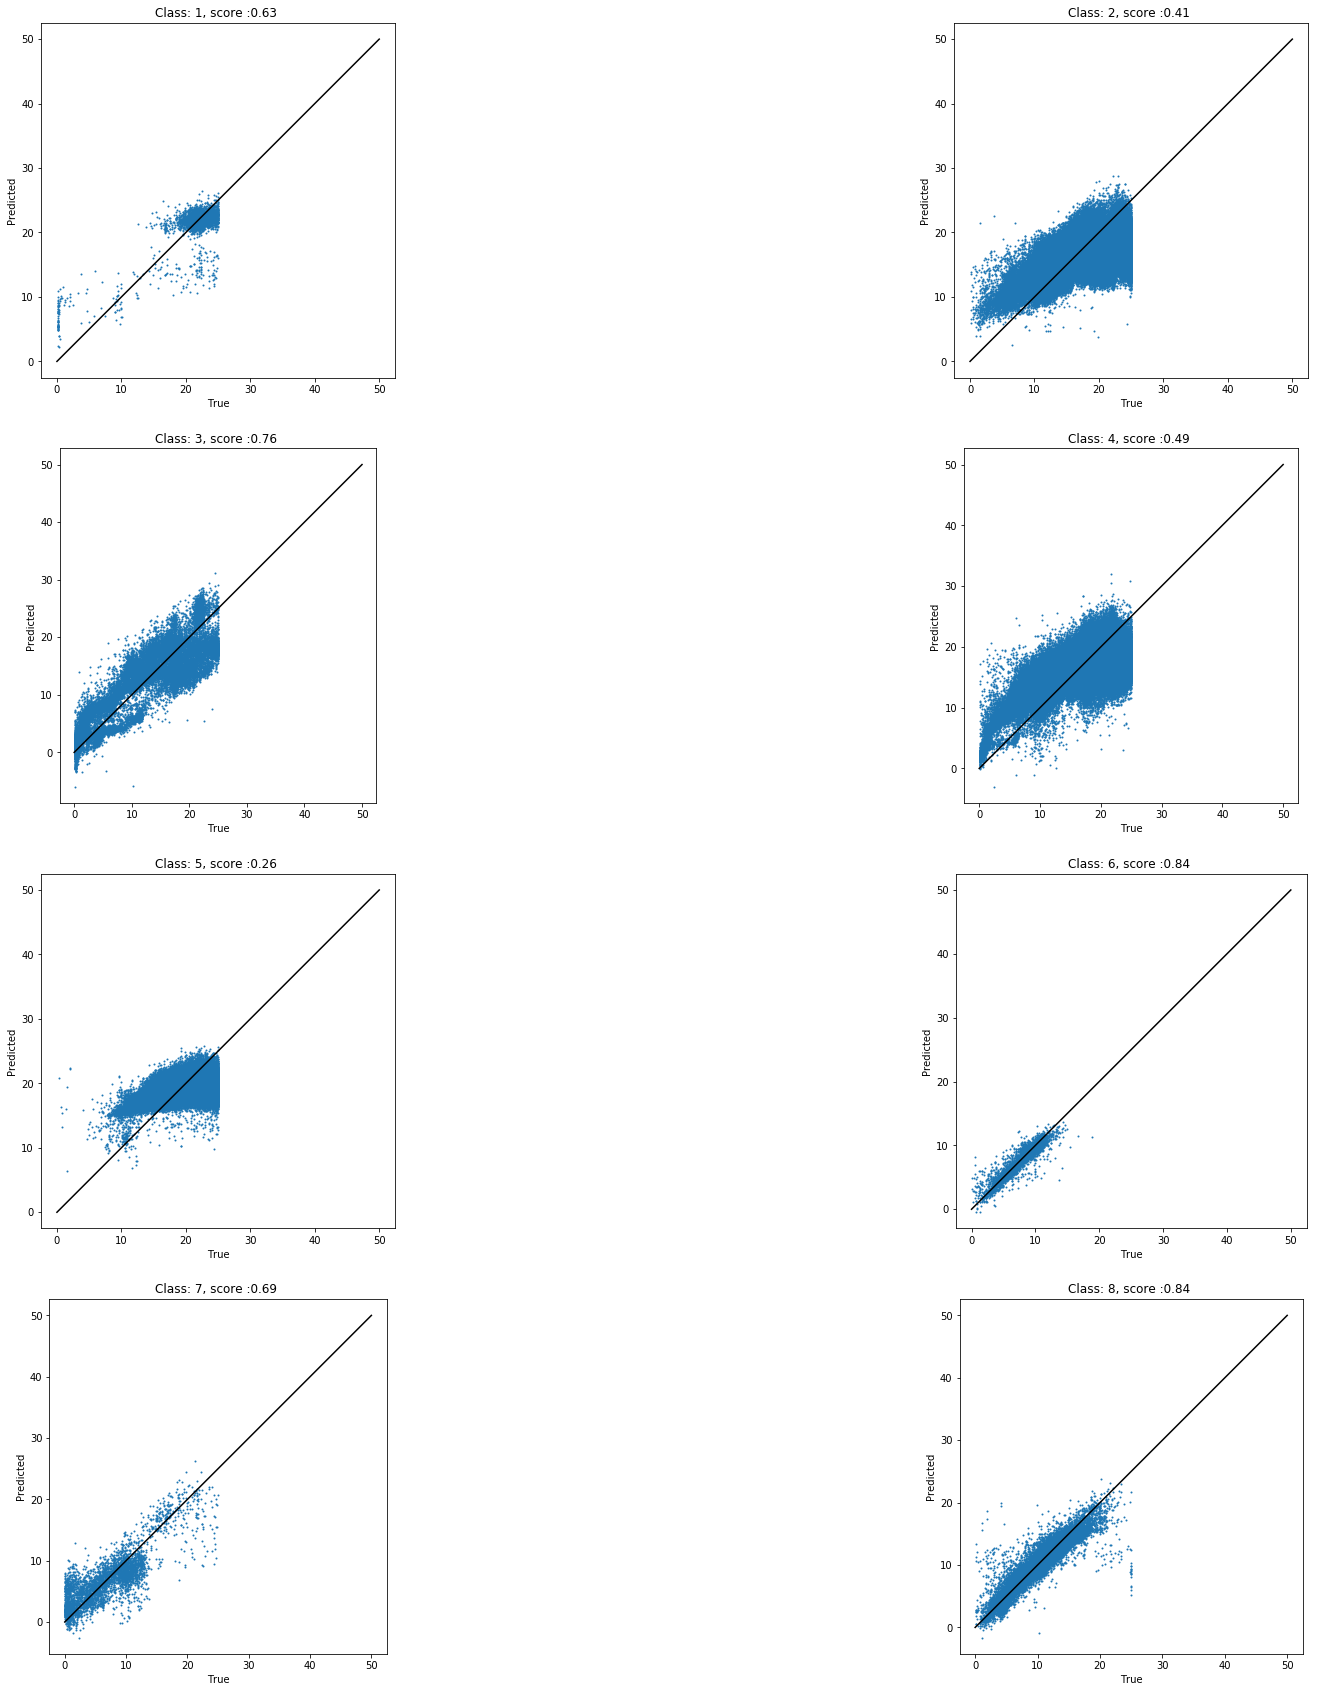

In [73]:
plt.figure(figsize=(30, 30))
models = {}
count = 1 
for c in np.unique(clusters_Classif):
    if c ==0:
        continue
    ind = (clusters_Classif==c) * (SurveyIndex>0) * index
    models[c] = LyzengaMod()
    models[c].fit(X[ind], SurveyValues[ind].reshape(np.sum(ind),1))
    print(models[c].score)
    plt.subplot(4, 2, count, aspect='equal')
    plt.scatter(x=SurveyValues[ind], y=models[c].predict(X[ind]),s=1)
    plt.xlabel('True')
    plt.ylabel('Predicted')
    plt.plot([0, 50],[0, 50], c='k')
    plt.title('Class: {0:d}, score :{1:0.2f} '.format(c, models[c].score['R2']))
    count = count +1

'plt.colorbar()'

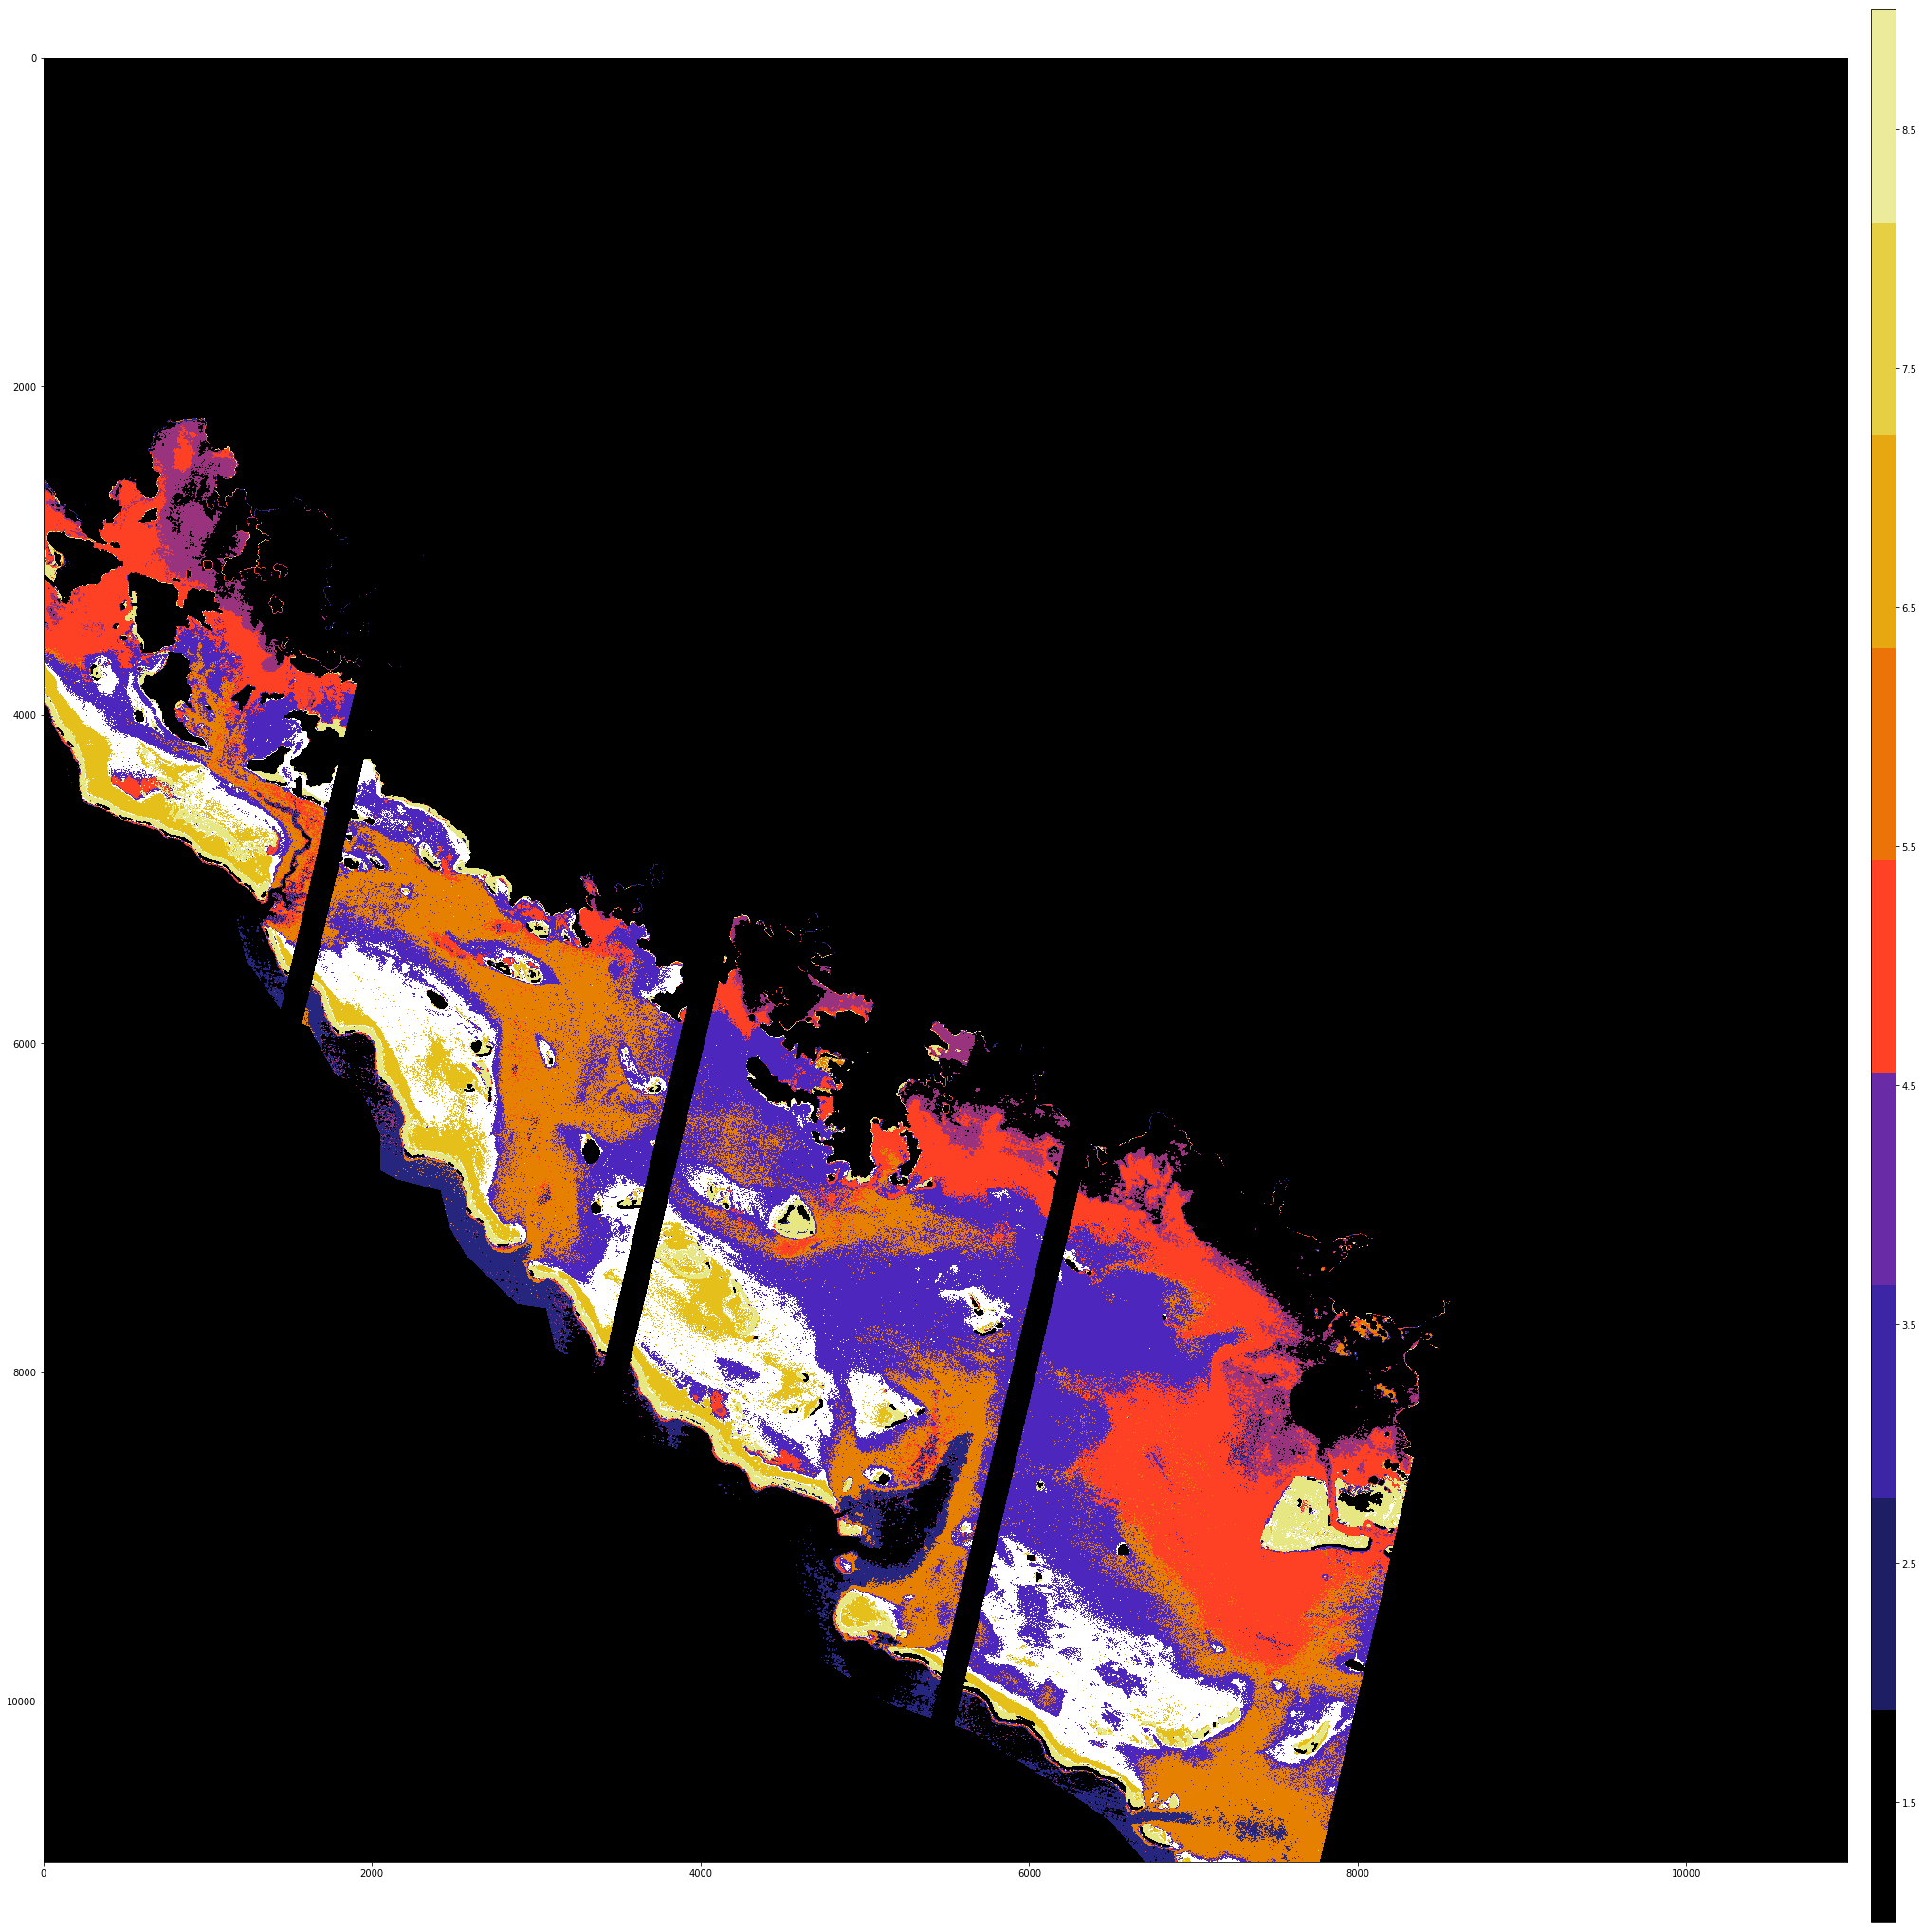

In [25]:

fig = plt.figure(figsize=(35, 35))

plt.imshow(clusters_Classif, cmap=plt.get_cmap('CMRmap'))


num_colors = 10
cm = plt.get_cmap('CMRmap') 
scheme = [cm(i*1./num_colors) for i in range(num_colors)] 
bins = np.linspace(1, 9, num_colors)  
ax_legend = fig.add_axes([0.9, 0.1, 0.01, 0.8]) 
cmap = mpl.colors.ListedColormap(scheme)
cb = mpl.colorbar.ColorbarBase(ax_legend, cmap=cmap, ticks=bins, boundaries=bins, orientation='vertical')
cb.set_ticks([i+0.5 for i in range(1, num_colors+1, 1)])  

cb.set_ticklabels([str(i+0.5) for i in range(1, num_colors+1, 1)])

'''plt.colorbar()'''

In [27]:
np.linspace(1, 9, num_colors) 

array([ 1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9.])

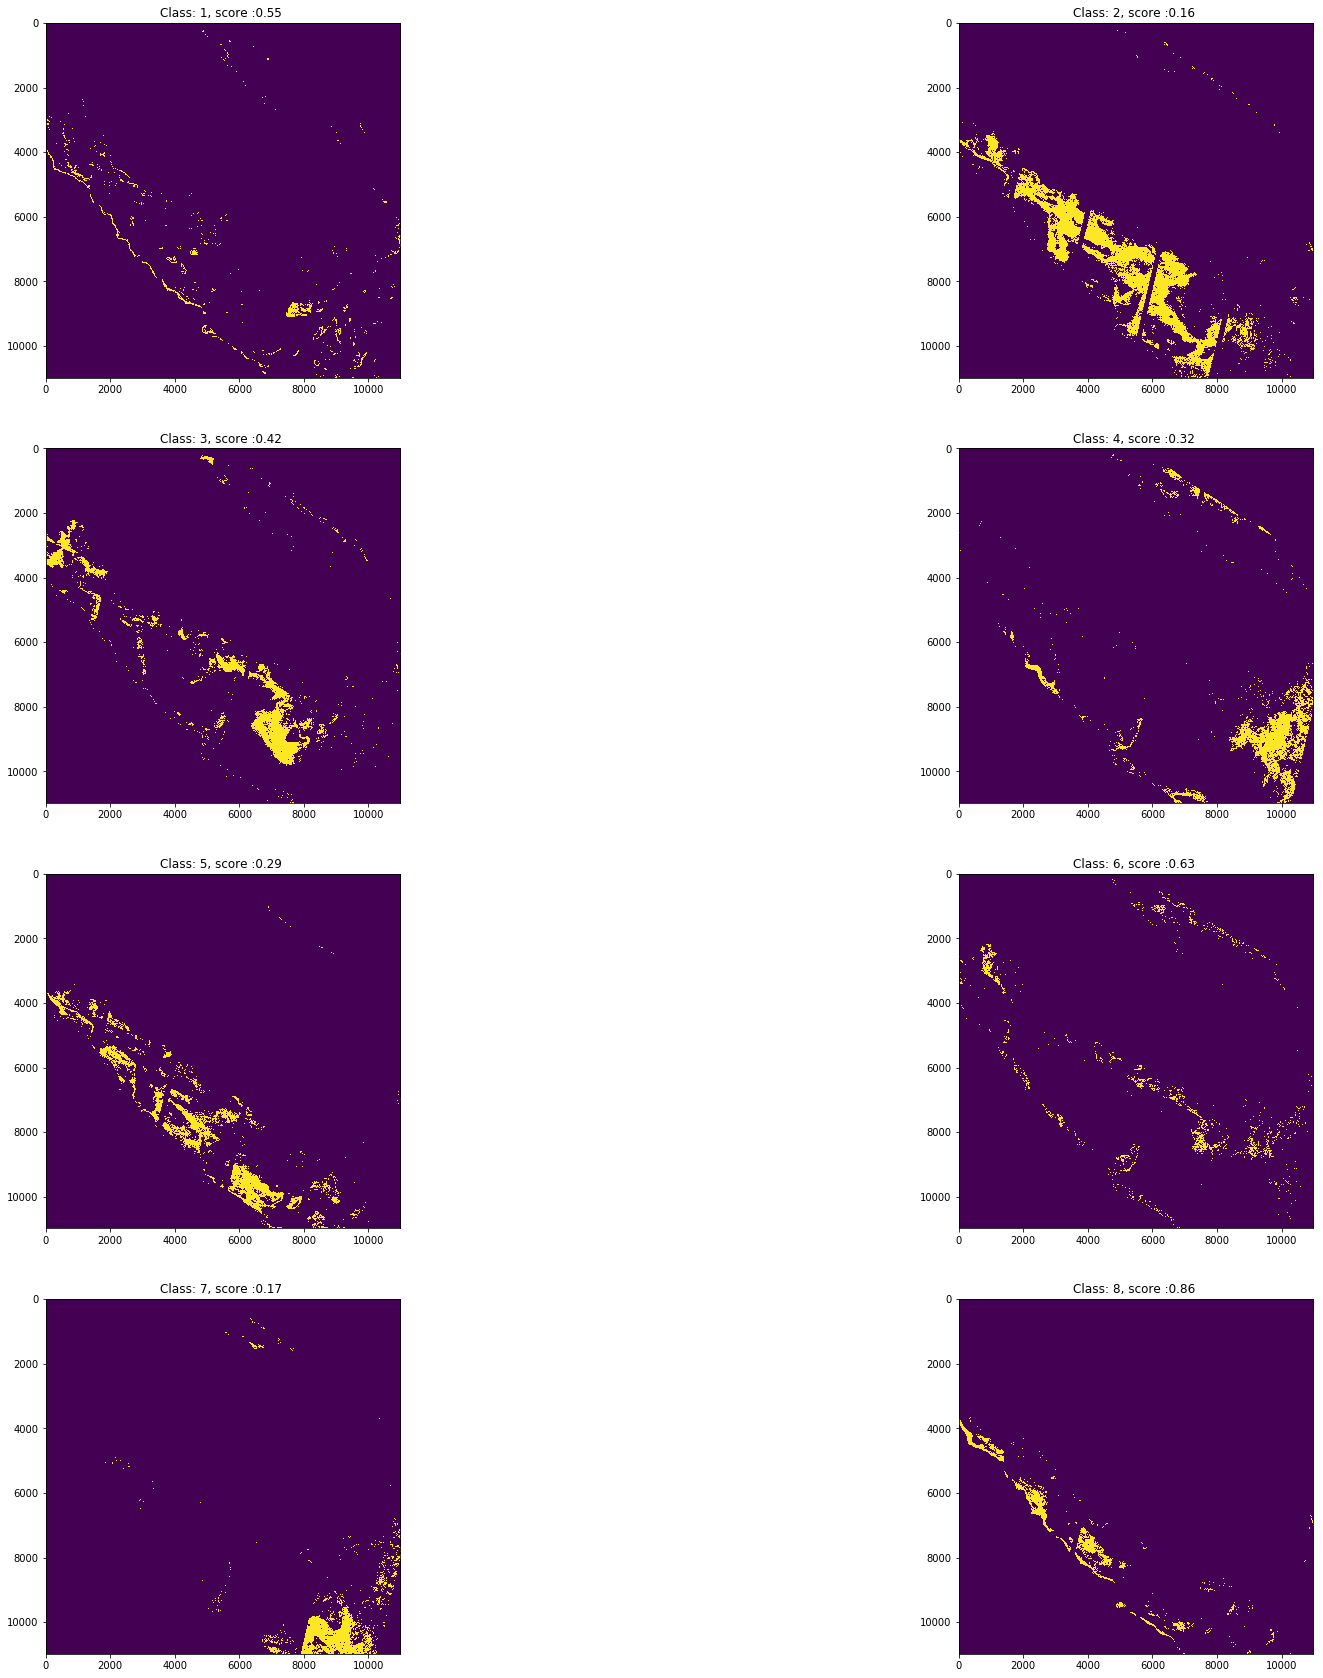

In [22]:
plt.figure(figsize=(35, 35))
count = 1 
for i in np.unique(clusters_Classif):
    if i ==0:
        continue
    plt.subplot(4, 2, count, aspect='equal')
    plt.imshow(clusters_Classif==i)
    plt.title('Class: {0:d}, score :{1:0.2f} '.format(i, models[i].score['R2']))
    count = count +1

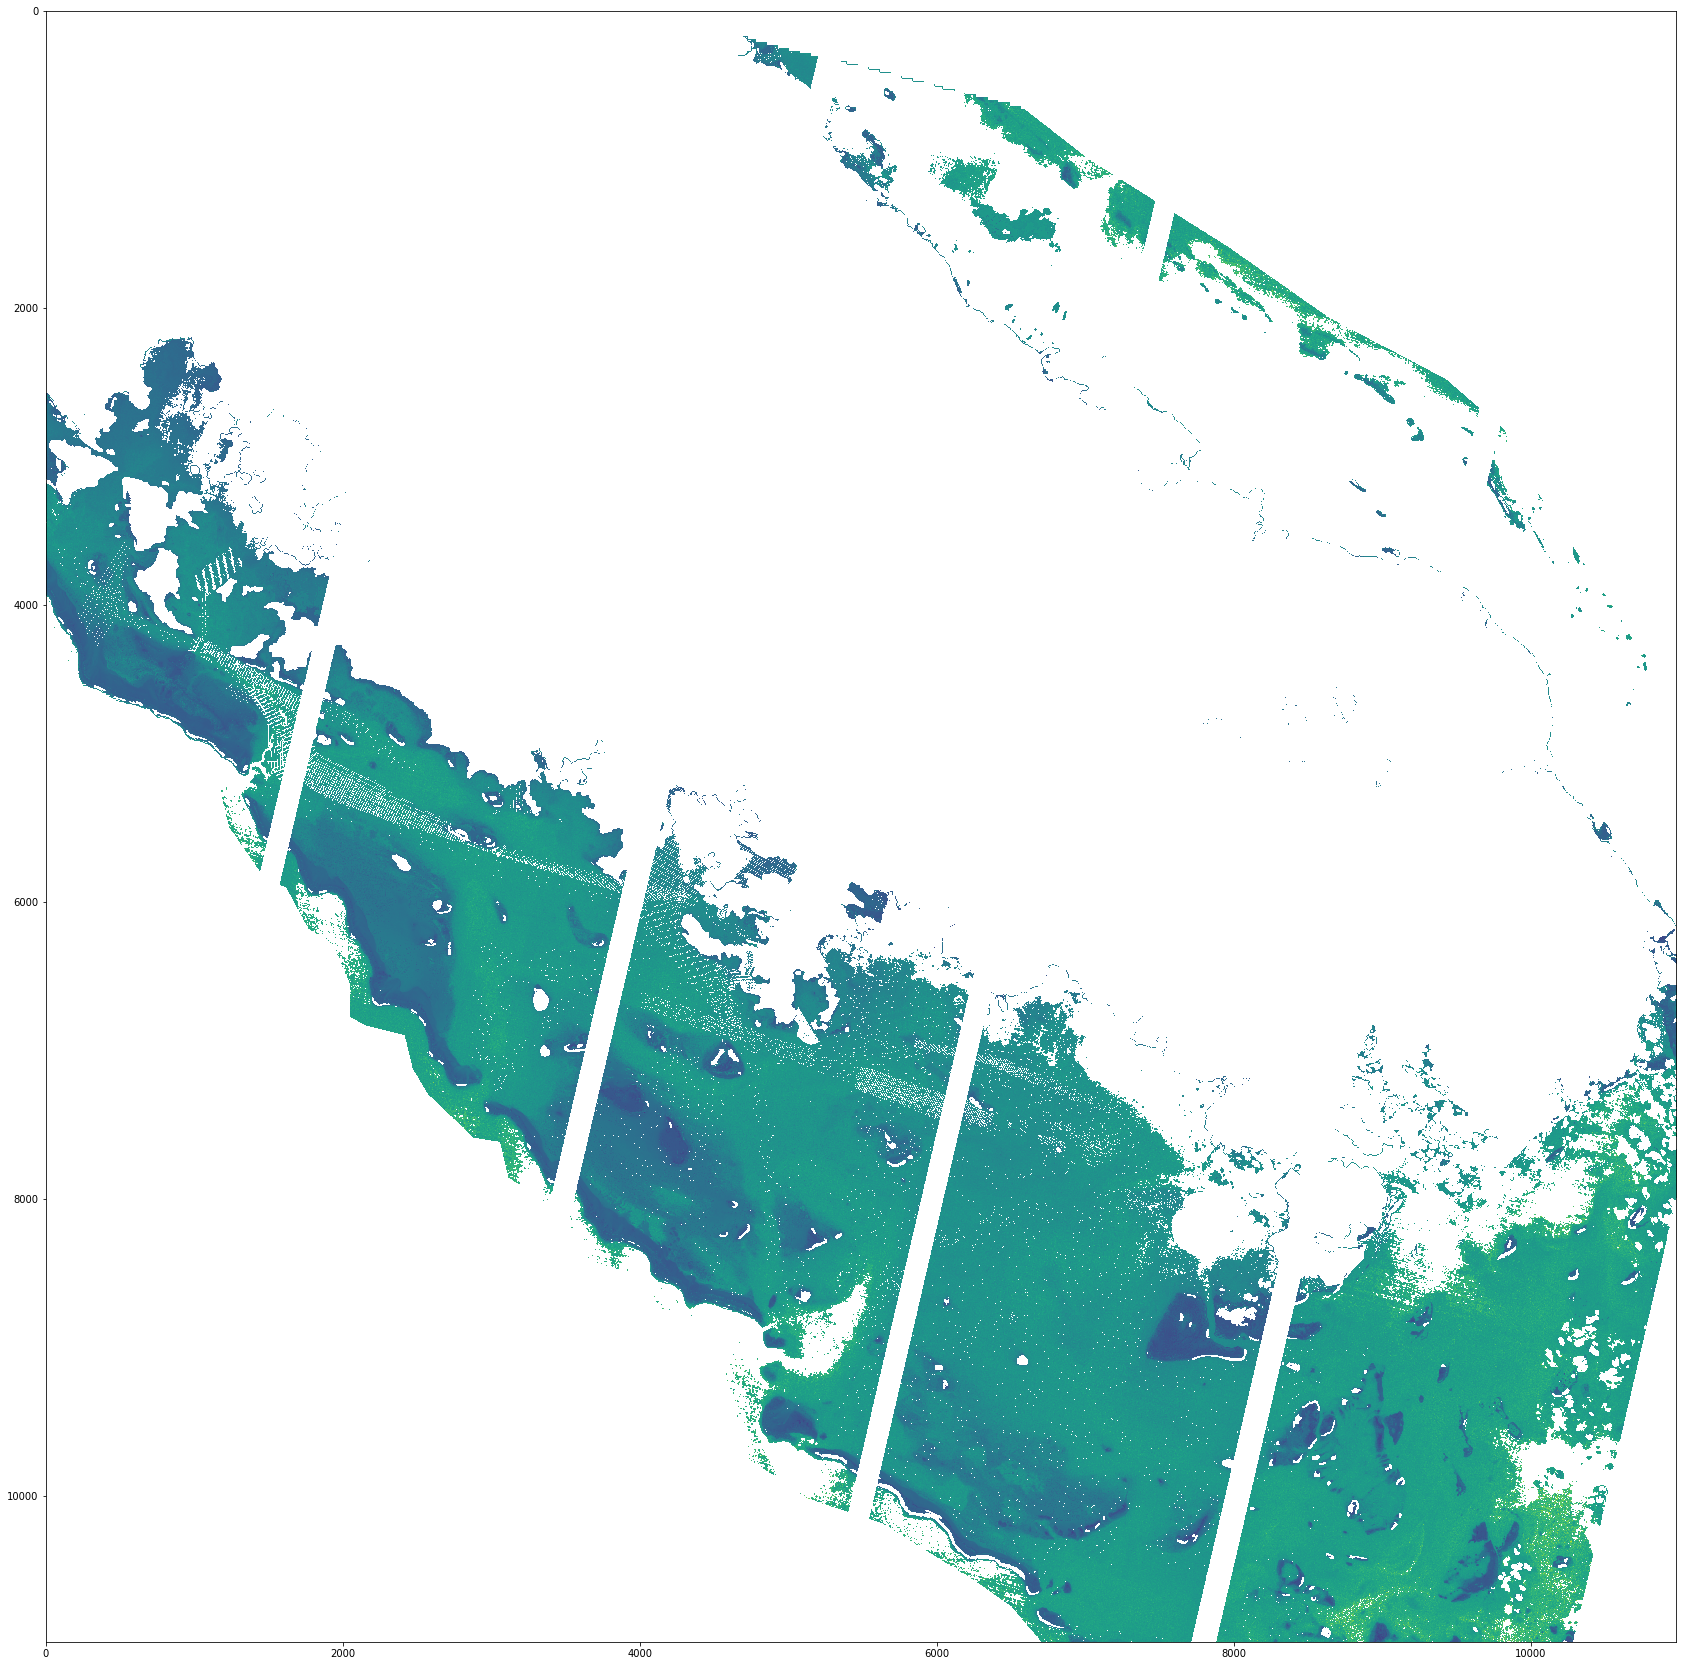

In [23]:
EstimateValues = np.full(ClassifIndex.shape, np.NaN, dtype= np.float_)

for i in np.unique(clusters_Classif):
    if i ==0:
        continue
    ind = np.logical_and(clusters_Classif==i, ~SurveyIndex)
    EstimateValues[ind] = models[i].predict(X[ind]).reshape(np.sum(ind),)

plt.figure(figsize=(30, 30))
plt.imshow(EstimateValues)

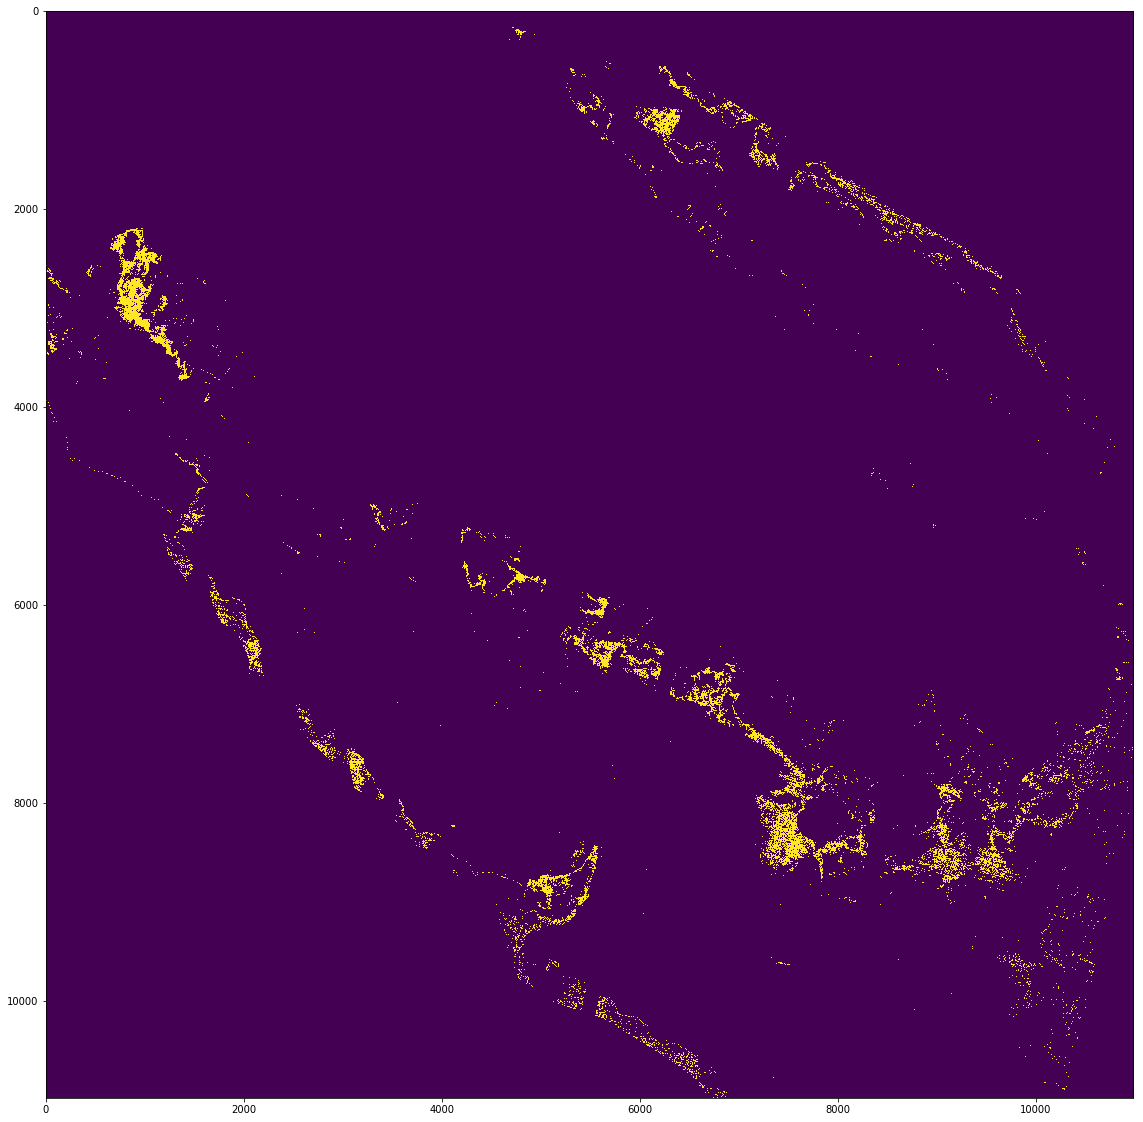

In [30]:
plt.figure(figsize=(20, 20))

plt.imshow(clusters_Classif==6)

In [24]:
write_raster2('EstimsateBathy.tiff', EstimateValues, src_ds.GetGeoTransform(), src_ds.GetProjection(), DriverName="GTiff", formatMem=gdal.GDT_Float64)

In [35]:
clusters_band = Classif.GetRasterBand(1)

driver = ogr.GetDriverByName("ESRI Shapefile")
if os.path.exists(Classif_Tiff_File[:-4]+".shp"):
    driver.DeleteDataSource(Classif_Tiff_File[:-4]+".shp")
outDatasource = driver.CreateDataSource(Classif_Tiff_File[:-4]+ ".shp")
outLayer = outDatasource.CreateLayer(Classif_Tiff_File[:-4], srs=None)
gdal.Polygonize( clusters_band, None, outLayer, -1, [], callback=None )
outDatasource.Destroy()
sourceRaster = None

In [36]:
help(gdal.Polygonize)

Help on function Polygonize in module osgeo.gdal:

Polygonize(*args, **kwargs)
    Polygonize(Band srcBand, Band maskBand, Layer outLayer, int iPixValField, char ** options=None, GDALProgressFunc callback=0, void * callback_data=None) -> int

